# 倫敦房價預測 - 探索性資料分析 (EDA)

## 1. 匯入函式庫

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats # For Q-Q plots
import sys
import os

# 添加中文字支持
font_preferences = [
    'Microsoft JhengHei',
    'SimHei',
    'sans-serif'
]
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = font_preferences
plt.rcParams['axes.unicode_minus'] = False
# 不知道為啥還是會報錯啊啊啊啊，有人要幫忙修嗎?

# 將 src 目錄加入到 Python 路徑中，以便導入 data_loader
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.data_loader import load_data

# 設定 Matplotlib 和 Seaborn 的樣式
plt.style.use('ggplot')
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None) 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 2. 載入數據

In [2]:
train_df, test_df = load_data(base_path='..')

成功載入訓練數據: ..\train.csv
成功載入測試數據: ..\test.csv


## 3. 數據基本資訊概覽

### 3.1 訓練數據

In [ ]:
if train_df is not None:
    print("訓練數據維度:", train_df.shape)
    display(train_df.head())
    train_df.info()
    display(train_df.describe())
    display(train_df.describe(include=['object', 'category']))
else:
    print("訓練數據載入失敗。")

### 3.2 測試數據

In [ ]:
if test_df is not None:
    print("測試數據維度:", test_df.shape)
    display(test_df.head())
    test_df.info()
    display(test_df.describe())
    display(test_df.describe(include=['object', 'category']))
else:
    print("測試數據載入失敗。")

## 4. 目標變數分析 (`price`) 的再探討

**行動：** 畫出 `price` 的直方圖和 Q-Q plot。然後，進行 log transformation (或其他你認為合適的轉換，例如 Box-Cox)，再畫一次直方圖和 Q-Q plot。比較轉換前後的分佈。

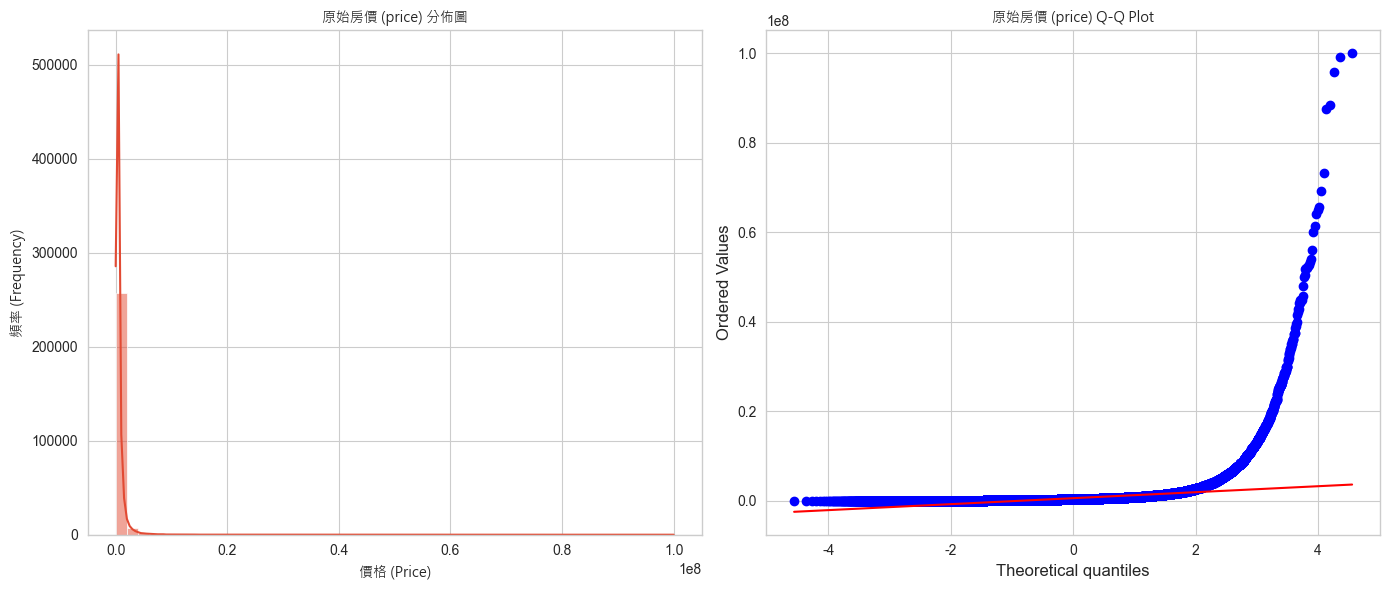

原始房價偏度 (Skewness): 22.81
原始房價峰度 (Kurtosis): 1033.73


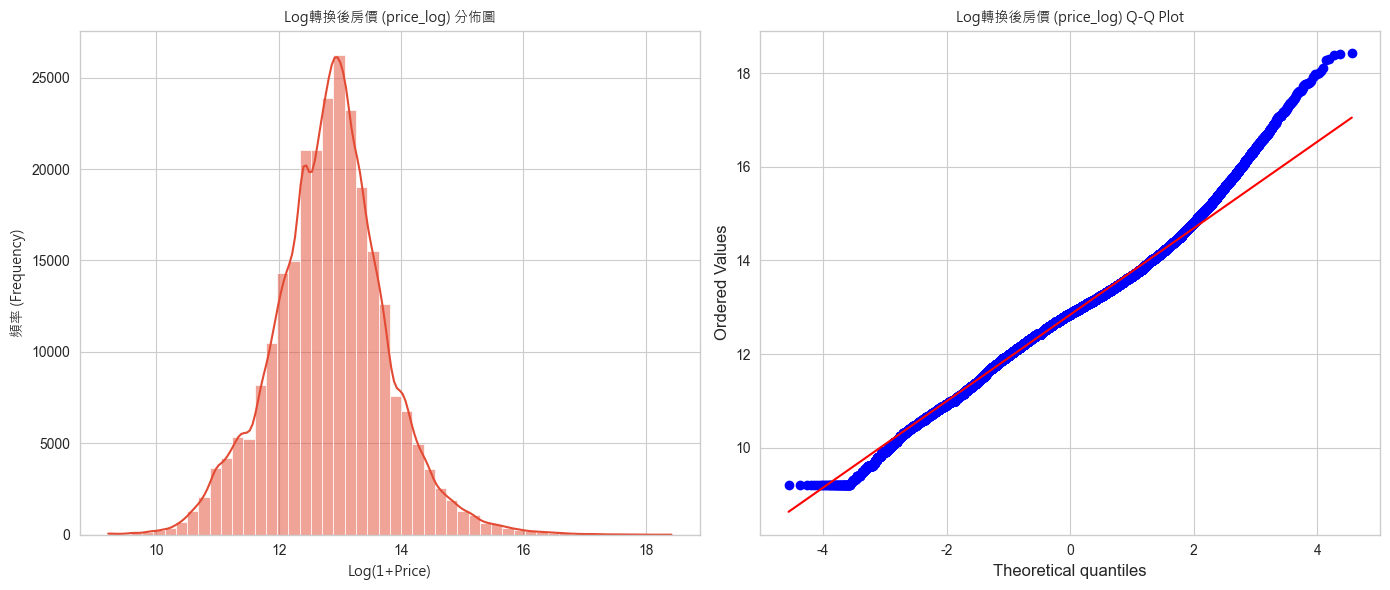

Log轉換後房價偏度 (Skewness): 0.13
Log轉換後房價峰度 (Kurtosis): 0.98


In [4]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
# 假設 train_df 已經載入

# --- 請確保您已經定義了這個中文字型物件 ---
# 例如：
font_path = 'C:\\Windows\\Fonts\\msjh.ttc' # 微軟正黑體字型檔案路徑
chinese_font = fm.FontProperties(fname=font_path)
# --- End of font definition ---

if train_df is not None and 'price' in train_df.columns:
    # 原始 price 分佈與 Q-Q plot
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(train_df['price'], kde=True, bins=50)
    plt.title('原始房價 (price) 分佈圖', fontproperties=chinese_font) # 因為未知bug，需要手動加上字型屬性
    plt.xlabel('價格 (Price)', fontproperties=chinese_font)
    plt.ylabel('頻率 (Frequency)', fontproperties=chinese_font)

    plt.subplot(1, 2, 2)
    stats.probplot(train_df['price'], plot=plt)
    plt.gca().set_title('原始房價 (price) Q-Q Plot', fontproperties=chinese_font) 

    plt.tight_layout()
    plt.show()
    print(f"原始房價偏度 (Skewness): {train_df['price'].skew():.2f}")
    print(f"原始房價峰度 (Kurtosis): {train_df['price'].kurt():.2f}")

    # Log 轉換後的 price_log 分佈與 Q-Q plot
    train_df['price_log'] = np.log1p(train_df['price']) # 確保 price 是存在的欄位
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(train_df['price_log'], kde=True, bins=50)
    plt.title('Log轉換後房價 (price_log) 分佈圖', fontproperties=chinese_font)
    plt.xlabel('Log(1+Price)', fontproperties=chinese_font)
    plt.ylabel('頻率 (Frequency)', fontproperties=chinese_font)

    plt.subplot(1, 2, 2)
    stats.probplot(train_df['price_log'], plot=plt)
    plt.gca().set_title('Log轉換後房價 (price_log) Q-Q Plot', fontproperties=chinese_font)

    plt.tight_layout()
    plt.show()
    print(f"Log轉換後房價偏度 (Skewness): {train_df['price_log'].skew():.2f}")
    print(f"Log轉換後房價峰度 (Kurtosis): {train_df['price_log'].kurt():.2f}")

**討論：**
原始房價的偏度和峰度指出了數據極度右偏且具有非常尖銳的峰和極長的厚尾。進行 log 轉換後，使得分布形態非常接近常態分佈，那滿不錯的。第二組圖中的直方圖呈現出更為對稱的鐘形，Q-Q 圖上的數據點也大體貼合理論直線。

不過Log 轉換後的 Q-Q 圖，你會發現兩端尾部，尤其是右尾，仍然存在輕微但可見的向上偏離趨勢，如果想要進一步分析，需要考慮以下幾個需要思考的問題：

- 這些造成偏離的數據點對應的是哪些房產？是不是那些價格在數千萬甚至上億英鎊的極端高價房產？數量有多少？
- 對模型的潛在影響：雖然 log 轉換已經極大地改善了分佈，使得標準的回歸模型容易被滿足，但尾部的異常值仍可能對某些模型（特別是對離群點敏感的模型或損失函數）產生不成比例的影響，對於樹模型來說，它們通常對目標變量的分佈形態不那麼敏感，但理解這些極端值的特性仍然有助於評估模型的泛化能力。

後續處理策略：
- 可以考慮對 Log 轉換後的數據再進行一次更細緻的離群點檢測與處理（如設定上限、移除極少數極端點）
- 或者嘗試其他轉換方式，如 Box-Cox transformation

## 5. 缺失值分析 (初步)

In [5]:
if train_df is not None:
    missing_train = train_df.isnull().sum()
    missing_train = missing_train[missing_train > 0].sort_values(ascending=False)
    missing_train_percent = (missing_train / len(train_df)) * 100
    missing_train_summary = pd.DataFrame({'缺失數量': missing_train, '缺失百分比': missing_train_percent})
    print("訓練數據中的缺失值:")
    if not missing_train_summary.empty:
        display(missing_train_summary)
    else:
        print("訓練數據中沒有缺失值。")

if test_df is not None:
    missing_test = test_df.isnull().sum()
    missing_test = missing_test[missing_test > 0].sort_values(ascending=False)
    missing_test_percent = (missing_test / len(test_df)) * 100
    missing_test_summary = pd.DataFrame({'缺失數量': missing_test, '缺失百分比': missing_test_percent})
    print("\n測試數據中的缺失值:")
    if not missing_test_summary.empty:
        display(missing_test_summary)
    else:
        print("測試數據中沒有缺失值。")

訓練數據中的缺失值:


,缺失數量,缺失百分比
currentEnergyRating,56814,21.333
bathrooms,48479,18.203
livingRooms,37040,13.908
bedrooms,24843,9.328
floorAreaSqM,13806,5.184
tenure,5721,2.148
propertyType,508,0.191



測試數據中的缺失值:


,缺失數量,缺失百分比
bathrooms,2624,15.858
livingRooms,2095,12.661
floorAreaSqM,2006,12.123
currentEnergyRating,1497,9.047
bedrooms,1375,8.310
tenure,590,3.566
propertyType,167,1.009


### 根據那篇discussion的說法，驗證看看是不是貴的房子缺失值比較大

房價的第 95 百分位數 (閾值): 1,700,000.00

數據集已根據價格分為兩組:
price_segment
Other 95%   0.949
Top 5%      0.051
Name: proportion, dtype: float64

--- 缺失值對比分析結果 ---


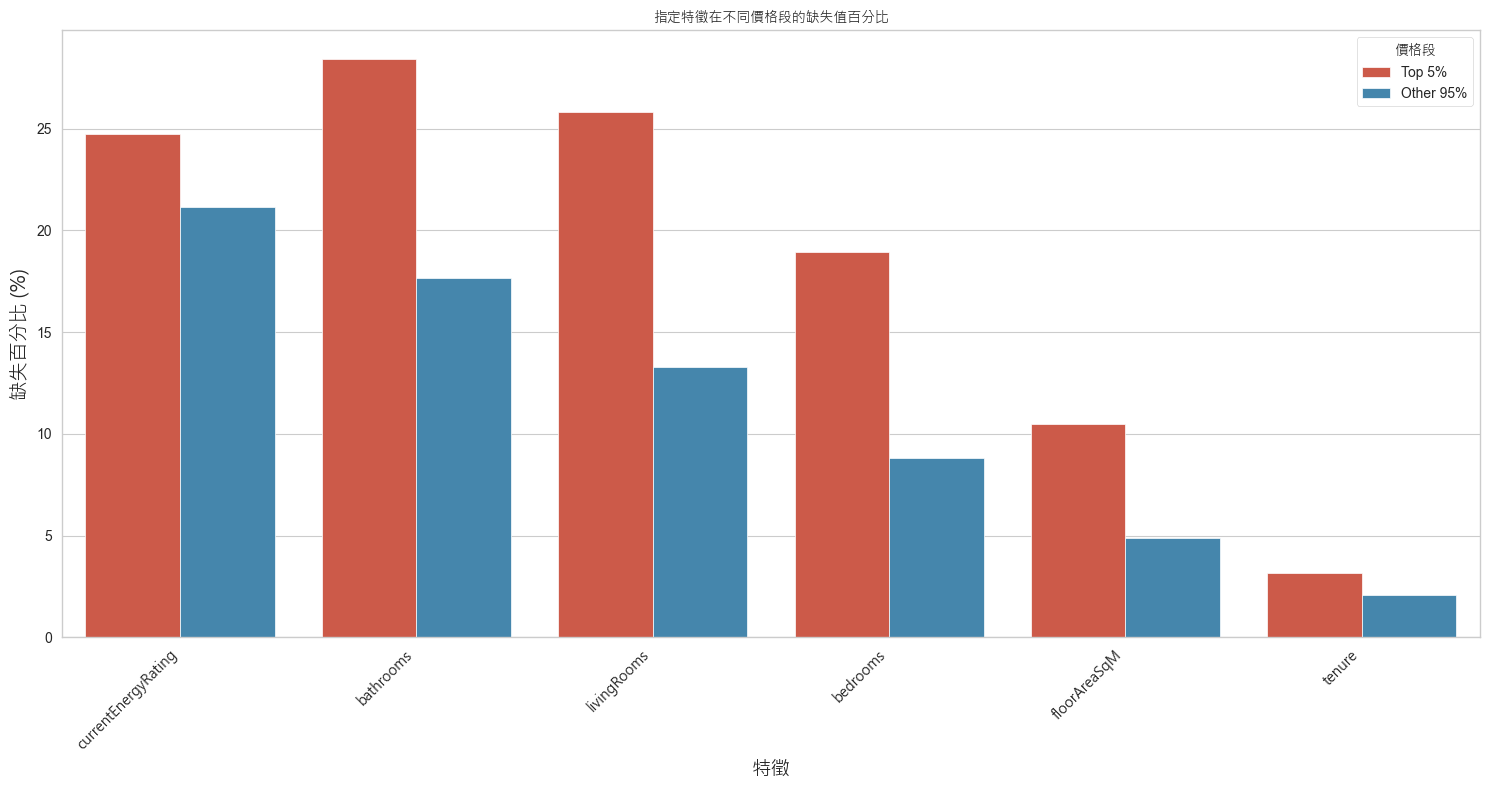

In [14]:
if train_df is not None and 'price' in train_df.columns:
    # 1. 確定閾值並進行分割
    price_threshold_95th = train_df['price'].quantile(0.95)
    print(f"房價的第 95 百分位數 (閾值): {price_threshold_95th:,.2f}")

    train_df_copy = train_df.copy() # 建立副本以避免修改原始 DataFrame
    train_df_copy['price_segment'] = train_df_copy['price'].apply(lambda x: 'Top 5%' if x >= price_threshold_95th else 'Other 95%')

    print(f"\n數據集已根據價格分為兩組:\n{train_df_copy['price_segment'].value_counts(normalize=True)}")

    # 2. 執行缺失值對比分析
    features_to_analyze = ['currentEnergyRating', 'bathrooms', 'livingRooms', 'bedrooms', 'floorAreaSqM', 'tenure']
    
    missing_analysis_results = []

    for feature in features_to_analyze:
        if feature not in train_df_copy.columns:
            print(f"\n警告: 特徵 '{feature}' 不在數據集中，跳過分析。")
            continue
            
        missing_top5 = train_df_copy[train_df_copy['price_segment'] == 'Top 5%'][feature].isnull().sum()
        missing_other95 = train_df_copy[train_df_copy['price_segment'] == 'Other 95%'][feature].isnull().sum()
        
        percent_missing_top5 = (missing_top5 / len(train_df_copy[train_df_copy['price_segment'] == 'Top 5%'])) * 100
        percent_missing_other95 = (missing_other95 / len(train_df_copy[train_df_copy['price_segment'] == 'Other 95%'])) * 100
        
        missing_analysis_results.append({
            'Feature': feature,
            'Group': 'Top 5%',
            'Missing Count': missing_top5,
            'Missing Percentage': percent_missing_top5
        })
        missing_analysis_results.append({
            'Feature': feature,
            'Group': 'Other 95%',
            'Missing Count': missing_other95,
            'Missing Percentage': percent_missing_other95
        })

    missing_df = pd.DataFrame(missing_analysis_results)
    
    print("\n--- 缺失值對比分析結果 ---")
    # 為了更清晰的表格顯示
    missing_pivot_table = missing_df.pivot_table(
        index='Feature', 
        columns='Group', 
        values=['Missing Count', 'Missing Percentage']
    )
    # 重新排列欄位順序，使 Missing Count 和 Missing Percentage 相鄰
    missing_pivot_table = missing_pivot_table.reindex(columns=['Missing Count', 'Missing Percentage'], level=0)
    missing_pivot_table = missing_pivot_table.reindex(columns=['Top 5%', 'Other 95%'], level=1)


    display(missing_pivot_table.style.format({
        ('Missing Percentage', 'Top 5%'): "{:.2f}%",
        ('Missing Percentage', 'Other 95%'): "{:.2f}%"
    }))

    # 視覺化缺失百分比
    plt.figure(figsize=(15, 8))
    sns.barplot(x='Feature', y='Missing Percentage', hue='Group', data=missing_df)
    plt.title('指定特徵在不同價格段的缺失值百分比', fontsize=16, fontproperties=chinese_font)
    plt.ylabel('缺失百分比 (%)', fontsize=14, fontproperties=chinese_font)
    plt.xlabel('特徵', fontsize=14, fontproperties=chinese_font)
    plt.xticks(rotation=45, ha='right', fontproperties=chinese_font)
    plt.legend(title='價格段', title_fontproperties=chinese_font)
    plt.tight_layout()
    plt.show()
else:
    print("錯誤：'train_df' 未定義或 'price' 欄位不存在。請先載入數據。")


**討論：**

根據分析，對於 bathrooms, bedrooms, floorAreaSqM, livingRooms 這四個核心結構特徵，任何試圖使用全局統計量進行的簡單插補，都將是嚴重的錯誤。

因為它們的缺失並非完全隨機，而是與房產是否屬於「高價」這個細分市場顯著相關。用整體數據的特性去填補這些高價房產的空白，幾乎必然會系統性地低估或扭曲這些頂級房產的真實屬性，進而嚴重影響模型對高價房的學習和預測能力。

可以考慮對缺失值做模型差補，或是把缺失值也當成一個特徵訓練。

如果要進一步分析，對於那些位於「Top 5%」但其核心結構特徵並未缺失的房產，它們的這些特徵值分析他們的分佈是怎樣的？這些「已知」的高價房特徵值，能否為模型插補提供一些線索或校準依據？

## 6. 地理位置資訊的深度挖掘 (`latitude`, `longitude`, `outcode`)

### 6.1 `outcode` 分析

**行動：** 分析完整 `outcode` 下的房價分佈（例如，用箱型圖比較不同 `outcode` 的中位數、四分位距）。檢查每個 `outcode` 內的樣本數是否充足，以及其內部房價的變異程度。

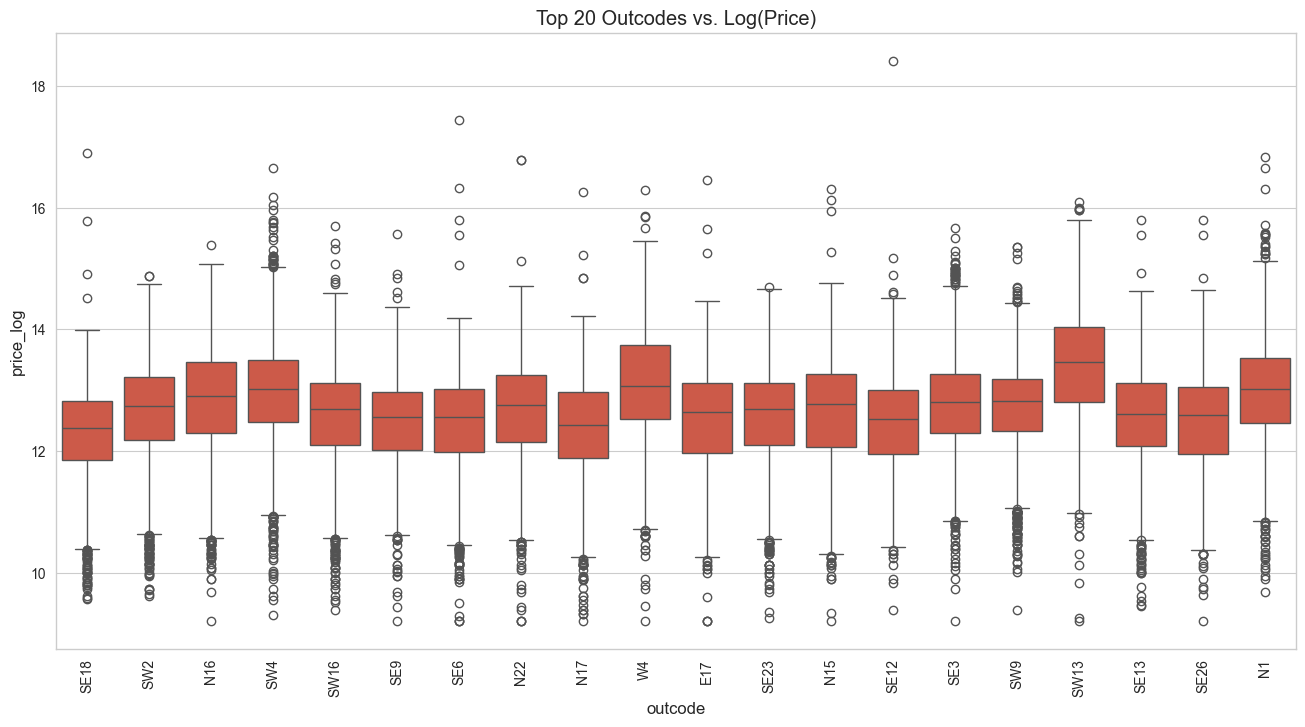

Outcode 房價摘要 (按樣本數排序):


,count,mean,median,std,min,max
outcode,,,,,,
SE18,4444,12.254,12.376,0.738,9.565,16.898
SW2,4440,12.670,12.747,0.801,9.616,14.885
N16,4163,12.851,12.899,0.877,9.210,15.394
SW4,4102,12.993,13.017,0.841,9.306,16.649
SW16,4006,12.581,12.692,0.814,9.393,15.700
SE9,3949,12.461,12.560,0.713,9.210,15.575
SE6,3642,12.441,12.568,0.771,9.210,17.435
N22,3504,12.658,12.766,0.802,9.210,16.790
N17,3423,12.350,12.429,0.774,9.210,16.262


In [15]:
# 分析 outcode 與 price_log 的關係
if train_df is not None and 'outcode' in train_df.columns and 'price_log' in train_df.columns:
    plt.figure(figsize=(16, 8))
    # 考慮到 outcode 種類可能很多，選擇 top N 或按樣本數過濾顯示
    top_outcodes = train_df['outcode'].value_counts().nlargest(20).index # 示例：顯示樣本數最多的前20個 outcode
    sns.boxplot(x='outcode', y='price_log', data=train_df[train_df['outcode'].isin(top_outcodes)], order=top_outcodes)
    plt.xticks(rotation=90)
    plt.title('Top 20 Outcodes vs. Log(Price)')
    plt.show()

    # 檢查各 outcode 樣本數和房價變異
    outcode_summary = train_df.groupby('outcode')['price_log'].agg(['count', 'mean', 'median', 'std', 'min', 'max']).sort_values(by='count', ascending=False)
    print("Outcode 房價摘要 (按樣本數排序):")
    display(outcode_summary.head(20)) # 顯示前20個

--- 1. outcode 的基數與頻次分佈 ---
數據集中總共有 167 個獨立的 outcode 值。


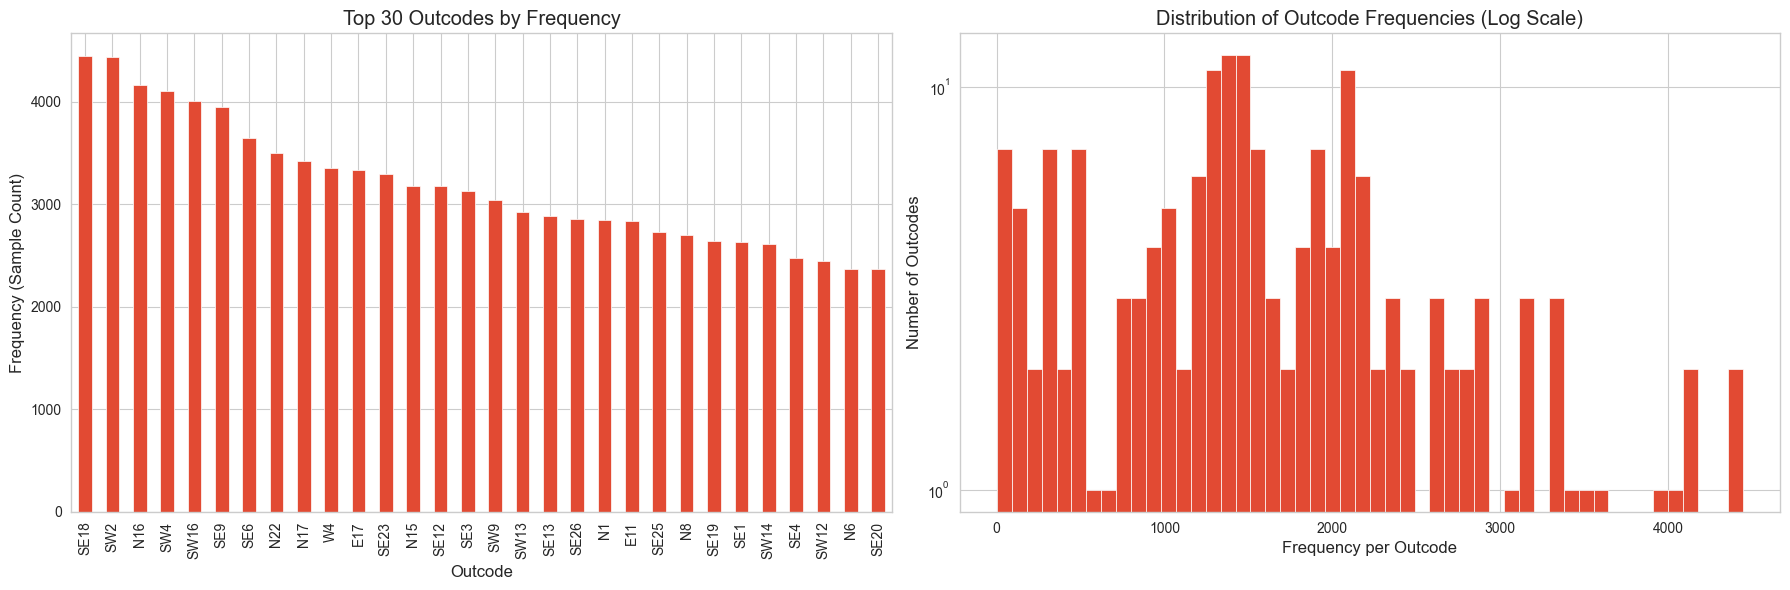


頻次最低的一些 outcode:


outcode
E1W     120
EC3A    100
EC4M     98
EC2M     72
WC2A     45
EC3V     17
EC2R      7
EC2V      7
W1C       3
EC3M      2
Name: count, dtype: int64


頻次最高的一些 outcode:


outcode
SE18    4444
SW2     4440
N16     4163
SW4     4102
SW16    4006
SE9     3949
SE6     3642
N22     3504
N17     3423
W4      3356
Name: count, dtype: int64



--- 2. 針對 Target Encoding 的穩健性分析 ---


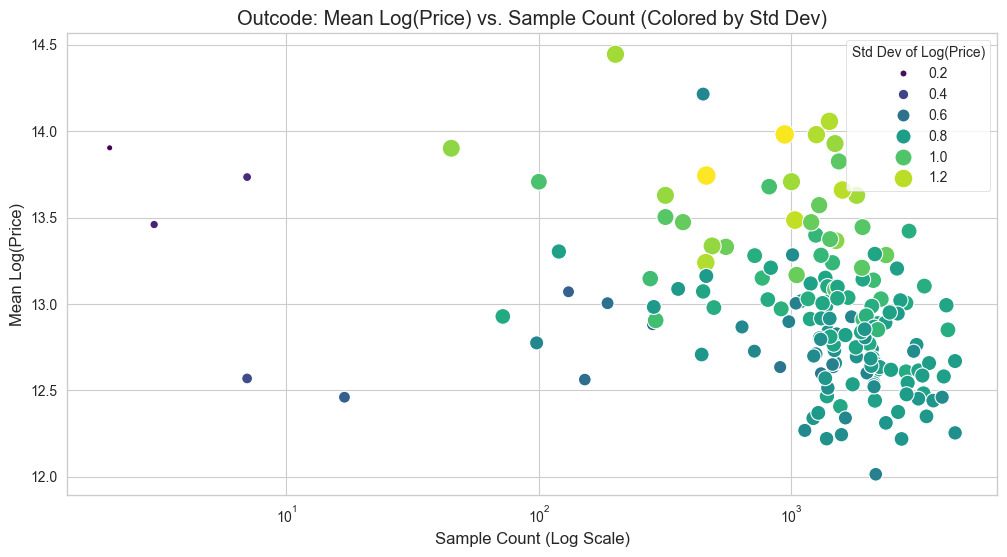


樣本量較小 (例如 < 10) 的 outcode 的價格統計:


,outcode,mean_log_price,median_log_price,sample_count,std_log_price
31,EC3M,13.904,13.904,2,0.161
134,W1C,13.460,13.331,3,0.270
28,EC2V,12.569,12.409,7,0.425
27,EC2R,13.735,13.709,7,0.297



樣本量較大 (例如 > 1000) 的 outcode 的價格統計:


,outcode,mean_log_price,median_log_price,sample_count,std_log_price
82,SE18,12.254,12.376,4444,0.738
119,SW2,12.670,12.747,4440,0.801
47,N16,12.851,12.899,4163,0.877
122,SW4,12.993,13.017,4102,0.841
107,SW16,12.581,12.692,4006,0.814
100,SE9,12.461,12.560,3949,0.713
97,SE6,12.441,12.568,3642,0.771
54,N22,12.658,12.766,3504,0.802
48,N17,12.350,12.429,3423,0.774
147,W4,13.104,13.066,3356,0.885




--- 3. 探索 outcode 分組/聚類的可行性 (基於價格分佈) ---


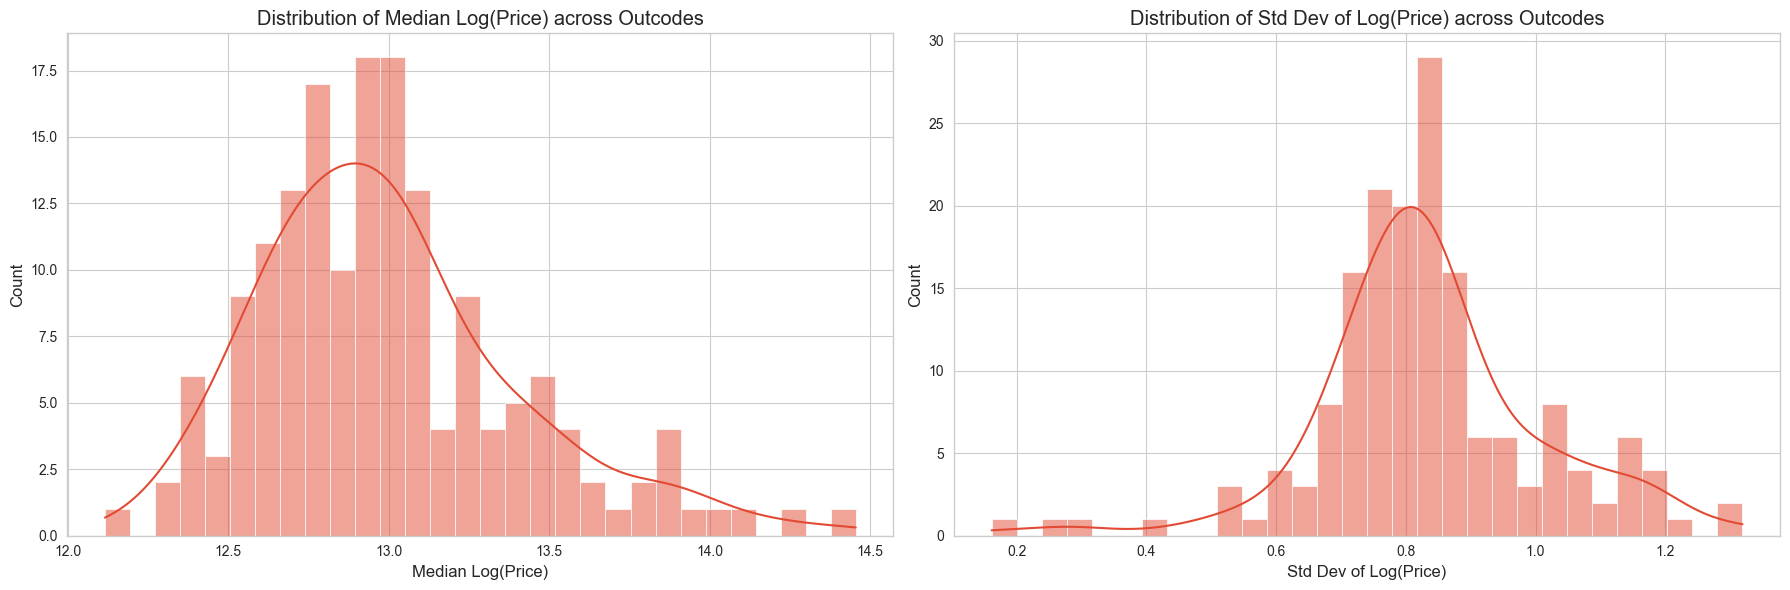

進一步的地理聚類需要 outcode 的中心座標，此處僅作價格分佈的初步觀察。
可以考慮結合 median_log_price 和 std_log_price 進行 k-means 聚類探索，
但要注意樣本量對 std_log_price 的影響。


--- 4. outcode 與其他關鍵特徵的交互作用分析深化 (以 propertyType 為例) ---
選取的代表性 Outcodes (樣本數 >= 200): ['N17', 'SW1X', 'N19']


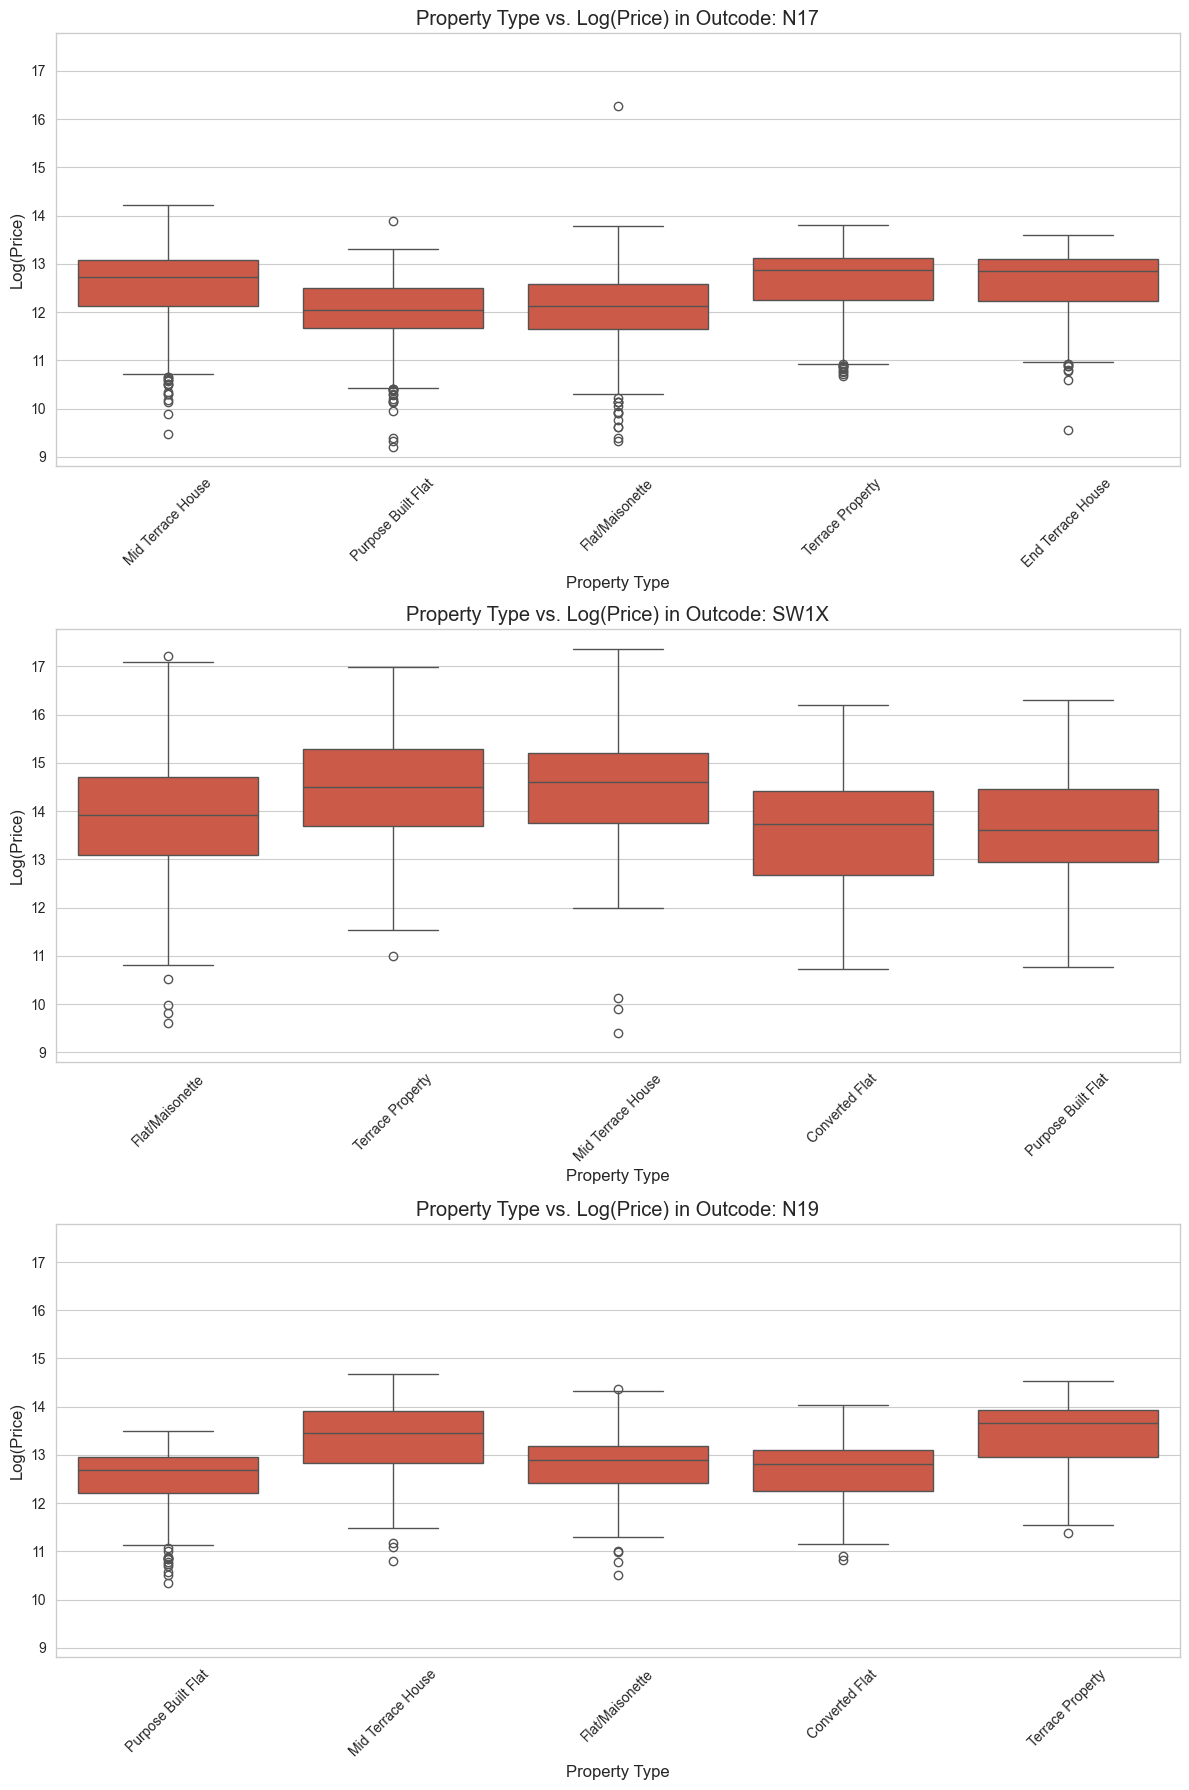

In [17]:
if train_df is not None and 'outcode' in train_df.columns and 'price_log' in train_df.columns:
    print("--- 1. outcode 的基數與頻次分佈 ---")
    outcode_counts = train_df['outcode'].value_counts()
    print(f"數據集中總共有 {len(outcode_counts)} 個獨立的 outcode 值。")

    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 2, 1)
    outcode_counts.head(30).plot(kind='bar') # 顯示頻次最高的 30 個 outcode
    plt.title('Top 30 Outcodes by Frequency')
    plt.xlabel('Outcode')
    plt.ylabel('Frequency (Sample Count)')
    plt.xticks(rotation=90)

    plt.subplot(1, 2, 2)
    plt.hist(outcode_counts, bins=50, log=True) # 使用對數刻度觀察整體分佈
    plt.title('Distribution of Outcode Frequencies (Log Scale)')
    plt.xlabel('Frequency per Outcode')
    plt.ylabel('Number of Outcodes')
    
    plt.tight_layout()
    plt.show()

    print("\n頻次最低的一些 outcode:")
    display(outcode_counts.tail(10))
    print("\n頻次最高的一些 outcode:")
    display(outcode_counts.head(10))

    print("\n\n--- 2. 針對 Target Encoding 的穩健性分析 ---")
    outcode_price_stats = train_df.groupby('outcode')['price_log'].agg(['mean', 'median', 'count', 'std']).reset_index()
    outcode_price_stats.rename(columns={'mean': 'mean_log_price', 
                                        'median': 'median_log_price', 
                                        'count': 'sample_count',
                                        'std': 'std_log_price'}, inplace=True)
    
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='sample_count', y='mean_log_price', data=outcode_price_stats, hue='std_log_price', size='std_log_price', sizes=(20,200), palette='viridis')
    plt.xscale('log') # 樣本數差異可能很大，使用對數刻度
    plt.title('Outcode: Mean Log(Price) vs. Sample Count (Colored by Std Dev)')
    plt.xlabel('Sample Count (Log Scale)')
    plt.ylabel('Mean Log(Price)')
    plt.legend(title='Std Dev of Log(Price)')
    plt.grid(True)
    plt.show()

    print("\n樣本量較小 (例如 < 10) 的 outcode 的價格統計:")
    display(outcode_price_stats[outcode_price_stats['sample_count'] < 10].sort_values(by='sample_count'))
    
    print("\n樣本量較大 (例如 > 1000) 的 outcode 的價格統計:")
    display(outcode_price_stats[outcode_price_stats['sample_count'] > 1000].sort_values(by='sample_count', ascending=False).head(10))


    print("\n\n--- 3. 探索 outcode 分組/聚類的可行性 (基於價格分佈) ---")
    # 觀察價格中位數和標準差的分佈，尋找自然的分組點
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(outcode_price_stats['median_log_price'], kde=True, bins=30)
    plt.title('Distribution of Median Log(Price) across Outcodes')
    plt.xlabel('Median Log(Price)')

    plt.subplot(1, 2, 2)
    sns.histplot(outcode_price_stats['std_log_price'].dropna(), kde=True, bins=30) # dropna 以防有單樣本outcode導致std為NaN
    plt.title('Distribution of Std Dev of Log(Price) across Outcodes')
    plt.xlabel('Std Dev of Log(Price)')
    plt.tight_layout()
    plt.show()
    
    print("進一步的地理聚類需要 outcode 的中心座標，此處僅作價格分佈的初步觀察。")
    print("可以考慮結合 median_log_price 和 std_log_price 進行 k-means 聚類探索，")
    print("但要注意樣本量對 std_log_price 的影響。")


    print("\n\n--- 4. outcode 與其他關鍵特徵的交互作用分析深化 (以 propertyType 為例) ---")
    # 選擇幾個有代表性的 outcode
    # 策略：選擇高價區 (e.g., median_log_price > 97.5th percentile), 中價區 (around median), 低價區 (e.g., < 2.5th percentile)
    # 並且確保這些 outcode 有足夠的樣本量 (e.g., > 200 samples)
    
    outcode_price_stats_filtered = outcode_price_stats[outcode_price_stats['sample_count'] >= 200] # 過濾樣本量
    if not outcode_price_stats_filtered.empty:
        high_price_outcodes_candidates = outcode_price_stats_filtered[outcode_price_stats_filtered['median_log_price'] > outcode_price_stats_filtered['median_log_price'].quantile(0.95)]
        median_price_outcodes_candidates = outcode_price_stats_filtered[
            (outcode_price_stats_filtered['median_log_price'] >= outcode_price_stats_filtered['median_log_price'].quantile(0.475)) &
            (outcode_price_stats_filtered['median_log_price'] <= outcode_price_stats_filtered['median_log_price'].quantile(0.525))
        ]
        low_price_outcodes_candidates = outcode_price_stats_filtered[outcode_price_stats_filtered['median_log_price'] < outcode_price_stats_filtered['median_log_price'].quantile(0.05)]

        representative_outcodes = []
        if not high_price_outcodes_candidates.empty:
            representative_outcodes.append(high_price_outcodes_candidates.sample(min(1, len(high_price_outcodes_candidates)), random_state=42)['outcode'].iloc[0])
        if not median_price_outcodes_candidates.empty:
            representative_outcodes.append(median_price_outcodes_candidates.sample(min(1, len(median_price_outcodes_candidates)), random_state=42)['outcode'].iloc[0])
        if not low_price_outcodes_candidates.empty:
            representative_outcodes.append(low_price_outcodes_candidates.sample(min(1, len(low_price_outcodes_candidates)), random_state=42)['outcode'].iloc[0])
        
        representative_outcodes = list(set(representative_outcodes)) # 去重

        if representative_outcodes and 'propertyType' in train_df.columns:
            print(f"選取的代表性 Outcodes (樣本數 >= 200): {representative_outcodes}")
            
            # 為每個代表性 outcode 繪製 propertyType vs log(price)
            num_outcodes_to_plot = len(representative_outcodes)
            if num_outcodes_to_plot > 0:
                fig, axes = plt.subplots(num_outcodes_to_plot, 1, figsize=(12, 6 * num_outcodes_to_plot), sharey=True)
                if num_outcodes_to_plot == 1: # 如果只有一個 outcode，axes 不是列表
                    axes = [axes] 

                for i, o_code in enumerate(representative_outcodes):
                    ax = axes[i]
                    data_subset = train_df[train_df['outcode'] == o_code]
                    # 僅顯示該 outcode 中 propertyType 數量較多的類別
                    top_property_types = data_subset['propertyType'].value_counts().nlargest(5).index
                    sns.boxplot(x='propertyType', y='price_log', 
                                data=data_subset[data_subset['propertyType'].isin(top_property_types)], 
                                ax=ax, order=top_property_types)
                    ax.set_title(f'Property Type vs. Log(Price) in Outcode: {o_code}')
                    ax.set_xlabel('Property Type')
                    ax.set_ylabel('Log(Price)')
                    ax.tick_params(axis='x', rotation=45)
                
                plt.tight_layout()
                plt.show()
            else:
                print("未能選出足夠樣本的代表性 outcode 進行交互分析。")

        elif not representative_outcodes:
            print("未能基於當前標準選出代表性的 outcode (高/中/低價位且樣本數 >= 200)。請調整篩選條件或檢查數據。")
        else:
            print("數據集中缺少 'propertyType' 欄位，無法進行交互分析。")
            
    else:
        print("沒有樣本數 >= 200 的 outcode，無法進行代表性 outcode 的交互分析。")

else:
    print("錯誤：'train_df' 未定義或 'outcode'/'price_log' 欄位不存在。請先載入並初步處理數據。")


### 6.2 `latitude` 和 `longitude` 地理散佈圖

**行動：** 利用 `latitude` 和 `longitude`：繪製房價的地理散佈圖，用顏色深淺表示價格高低。觀察是否存在肉眼可見的價格熱區或冷區，這些區域是否與 `outcode` 的邊界吻合？

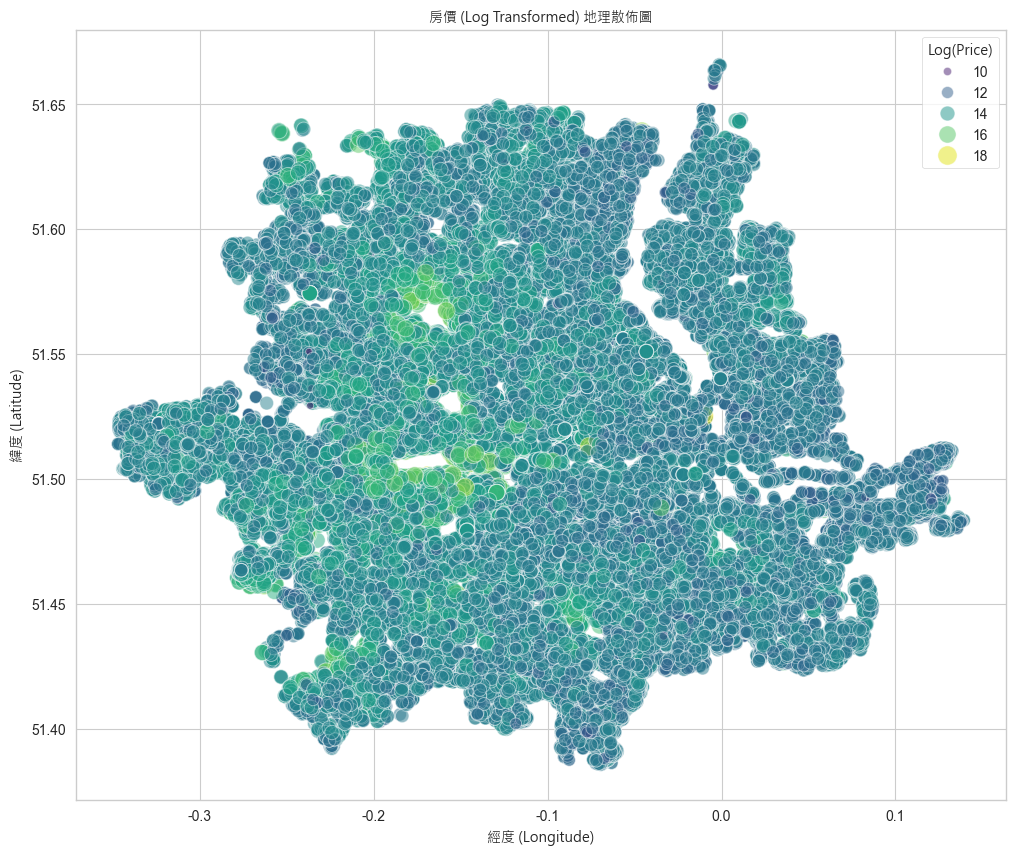

In [19]:
if train_df is not None and 'latitude' in train_df.columns and 'longitude' in train_df.columns and 'price_log' in train_df.columns:
    plt.figure(figsize=(12, 10))
    sns.scatterplot(x='longitude', y='latitude', hue='price_log', data=train_df, palette='viridis', size='price_log', sizes=(20, 200), alpha=0.5)
    plt.title('房價 (Log Transformed) 地理散佈圖', fontproperties=chinese_font)
    plt.xlabel('經度 (Longitude)', fontproperties=chinese_font)
    plt.ylabel('緯度 (Latitude)', fontproperties=chinese_font)
    plt.legend(title='Log(Price)', title_fontproperties=chinese_font)
    plt.show()

## 7. 時間特徵的精細化分析 (`sale_month`, `sale_year`)

**行動：**
*   拒絕年份分箱。將 `sale_year` 視為連續變量，繪製平均（或中位數）log(price) 隨 `sale_year` 的變化趨勢圖。
*   考慮創建一個從數據集起始日期開始的連續時間索引（例如，`months_since_start`）。
*   對於 `sale_month`：繪製每個月份的 log(price) 箱型圖，觀察是否存在一致的季節性模式。進一步，觀察特定月份的平均價格是否隨年份變化。
*   探索時間與其他特徵的交互作用。

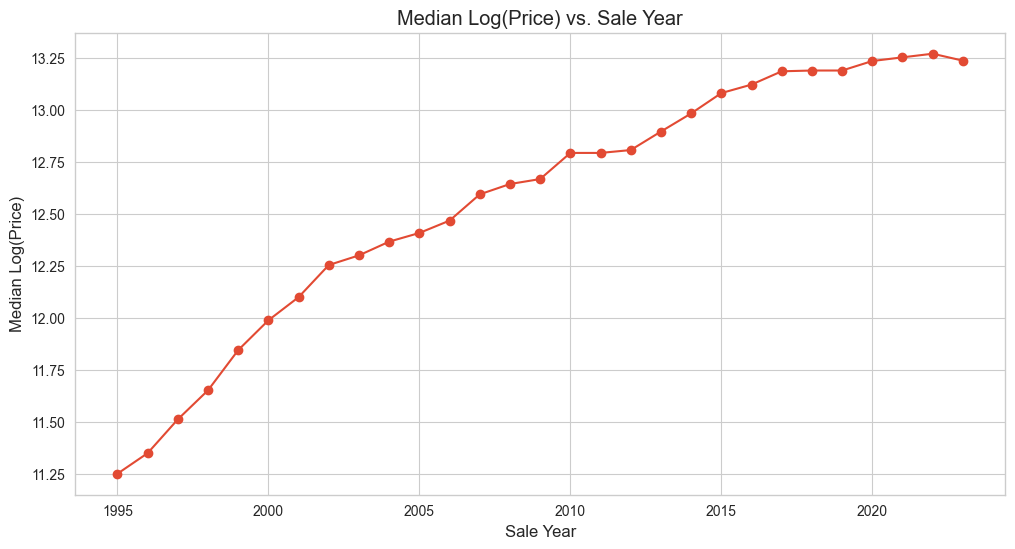

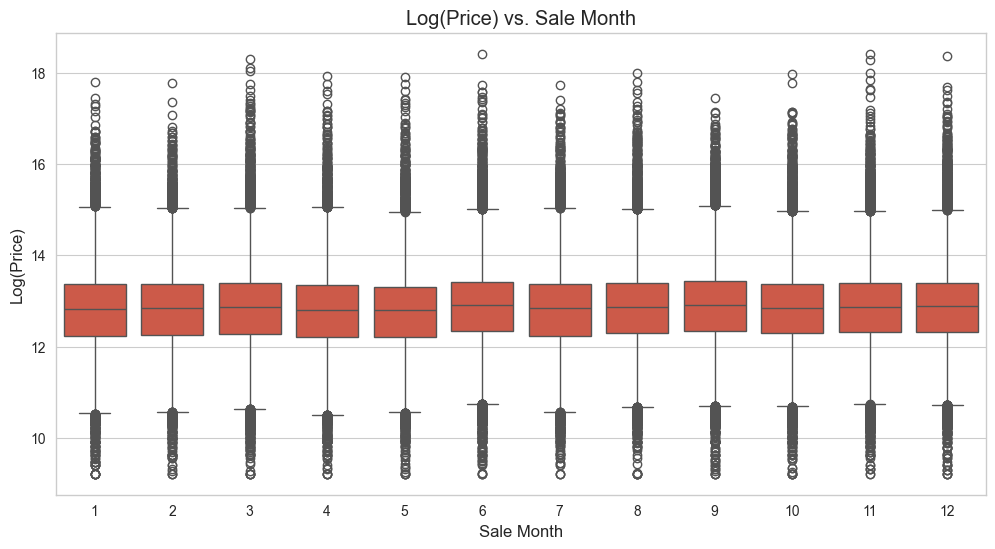

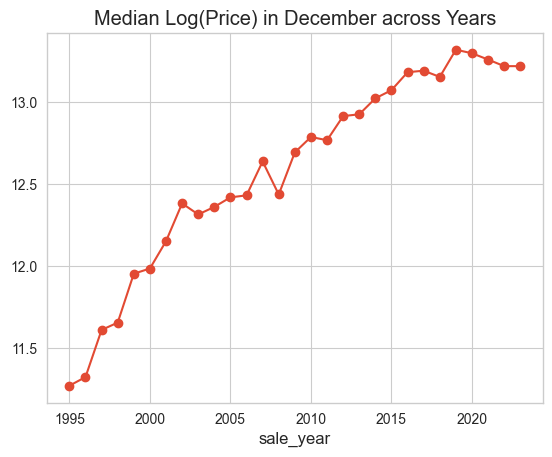

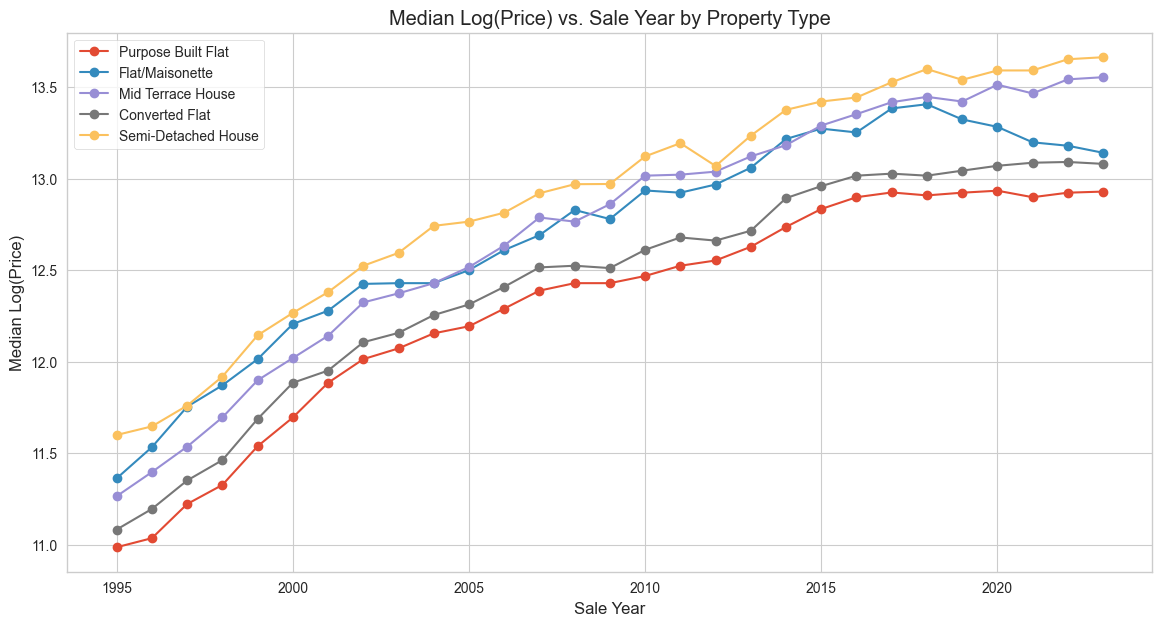

In [23]:
if train_df is not None:
    # sale_year vs price_log
    plt.figure(figsize=(12, 6))
    train_df.groupby('sale_year')['price_log'].median().plot(kind='line', marker='o')
    plt.title('Median Log(Price) vs. Sale Year')
    plt.ylabel('Median Log(Price)')
    plt.xlabel('Sale Year')
    plt.grid(True)
    plt.show()

    # 創建 months_since_start (概念)
    train_df['sale_date'] = pd.to_datetime(train_df['sale_year'].astype(str) + '-' + train_df['sale_month'].astype(str) + '-01')
    train_df['months_since_start'] = (train_df['sale_date'].dt.year - train_df['sale_date'].dt.year.min()) * 12 + train_df['sale_date'].dt.month - train_df['sale_date'].dt.month.min()

    # sale_month vs price_log
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='sale_month', y='price_log', data=train_df)
    plt.title('Log(Price) vs. Sale Month')
    plt.xlabel('Sale Month')
    plt.ylabel('Log(Price)')
    plt.show()

    # 特定月份的平均價格隨年份變化 (範例：12月)
    train_df[train_df['sale_month'] == 12].groupby('sale_year')['price_log'].median().plot(kind='line', marker='o')
    plt.title('Median Log(Price) in December across Years')
    plt.show()

    # 時間與其他特徵交互 (範例：propertyType 的年度價格趨勢差異)
    plt.figure(figsize=(14, 7))
    for p_type in train_df['propertyType'].value_counts().nlargest(5).index: # Top 5 property types
        train_df[train_df['propertyType'] == p_type].groupby('sale_year')['price_log'].median().plot(label=p_type, marker='o')
    plt.title('Median Log(Price) vs. Sale Year by Property Type')
    plt.ylabel('Median Log(Price)')
    plt.xlabel('Sale Year')
    plt.legend()
    plt.grid(True)
    plt.show()
    pass

**詰問與討論：**
*   你觀察到的2014年後價格波動，能否用更平滑的方式來建模，而不是粗暴地切分時段？
*   是否有外部事件（除了你猜測的疫情）可能影響了這些波動？

## 9. 交互作用的系統性探索 (Bivariate/Multivariate Analysis)

**行動：**
*   `floorAreaSqM` vs log(price) 的散佈圖，用 `outcode` (或聚類得到的地理區域) 對點進行著色或分面。
*   `bedrooms` (或 `bathrooms`) vs log(price) 的箱型圖，按 `propertyType` 分組。
*   `currentEnergyRating`：對於那些 「F」 和 「G」 評級但價格不低的房產，它們的 `floorAreaSqM`、`propertyType` 和 location 是什麼樣的？

In [ ]:
if train_df is not None:
    # floorAreaSqM vs price_log, colored by outcode (示例：用 Top 5 outcodes 著色，其他為 'Other')
    # top_5_outcodes = train_df['outcode'].value_counts().nlargest(5).index
    # train_df['outcode_group'] = train_df['outcode'].apply(lambda x: x if x in top_5_outcodes else 'Other')
    # plt.figure(figsize=(14, 7))
    # sns.scatterplot(x='floorAreaSqM', y='price_log', hue='outcode_group', data=train_df[train_df['floorAreaSqM'] < 500], alpha=0.5) # 限制面積以提高可讀性
    # plt.title('floorAreaSqM vs Log(Price) by Outcode Group')
    # plt.show()

    # bedrooms vs price_log, grouped by propertyType
    # plt.figure(figsize=(16, 8))
    # sns.boxplot(x='bedrooms', y='price_log', hue='propertyType', data=train_df)
    # plt.title('Bedrooms vs Log(Price) by Property Type')
    # plt.legend(loc='upper right')
    # plt.show()

    # 分析低能源評級但高價房產
    # low_energy_high_price = train_df[(train_df['currentEnergyRating'].isin(['F', 'G'])) & (train_df['price_log'] > train_df['price_log'].quantile(0.75))].copy()
    # print(f"低能源評級 (F/G) 且高價 (Top 25%) 的房產數量: {len(low_energy_high_price)}")
    # if not low_energy_high_price.empty:
    #     display(low_energy_high_price[['price', 'price_log', 'currentEnergyRating', 'floorAreaSqM', 'propertyType', 'outcode', 'bedrooms']].describe(include='all'))
    pass

**詰問與討論：**
*   哪些特徵組合起來對價格的解釋力最強？
*   是否存在某些特徵，只有在特定條件下才顯現出對價格的強烈影響？

## 10. 離群點的審慎對待

**行動：** 對於核心的連續特徵（如 `floorAreaSqM`, 轉換後的 `price`）以及計數特徵（如 `bedrooms`），使用箱型圖或 Z-score 等方法識別離群點。

In [ ]:
if train_df is not None:
    # 範例：floorAreaSqM 離群點分析
    # plt.figure(figsize=(12, 6))
    # sns.boxplot(x=train_df['floorAreaSqM'])
    # plt.title('floorAreaSqM Boxplot for Outlier Detection')
    # plt.show()

    # 範例：bedrooms 離群點分析
    # plt.figure(figsize=(12, 6))
    # sns.boxplot(x=train_df['bedrooms'])
    # plt.title('Bedrooms Boxplot for Outlier Detection')
    # plt.show()

    # Z-score 方法 (範例)
    # from scipy import stats
    # z_scores_area = np.abs(stats.zscore(train_df['floorAreaSqM'].dropna()))
    # outliers_area = train_df['floorAreaSqM'].dropna()[(z_scores_area > 3)]
    # print(f"floorAreaSqM Z-score > 3 的離群點數量: {len(outliers_area)}")
    pass

**詰問與討論：**
*   這些離群點是真實存在的極端情況，還是數據錯誤？
*   它們與其他特徵（尤其是高價房的 NaN 問題）有何關聯？
*   簡單移除離群點會不會丟失市場的某些真實動態？

## 11. 原有 EDA 項目 (可選擇性執行或參考)

### 11.1 數值特徵 (Numerical Features) - 初步掃描

In [ ]:
if train_df is not None:
    numerical_cols = train_df.select_dtypes(include=np.number).columns.tolist()
    if 'price' in numerical_cols: numerical_cols.remove('price')
    if 'price_log' in numerical_cols: numerical_cols.remove('price_log')
    if 'id' in numerical_cols: numerical_cols.remove('id') # 假設id是數值型
    
    print(f"數值型特徵 ({len(numerical_cols)}): {numerical_cols}")

    # for col in numerical_cols:
    #     plt.figure(figsize=(12, 5))
    #     plt.subplot(1, 2, 1)
    #     sns.histplot(train_df[col], kde=False, bins=30) # kde=False 加快速度
    #     plt.title(f'{col} 分佈圖')
    #     plt.subplot(1, 2, 2)
    #     if train_df[col].nunique() > 1: # 避免繪製常數欄位與價格的散點圖
    #        sns.scatterplot(x=train_df[col], y=train_df['price_log'])
    #        plt.title(f'{col} vs. Log(Price)')
    #     plt.tight_layout()
    #     plt.show()
    pass

### 11.2 類別特徵 (Categorical Features) - 初步掃描

In [ ]:
if train_df is not None:
    categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
    print(f"類別型特徵 ({len(categorical_cols)}): {categorical_cols}")

    # for col in categorical_cols:
    #     plt.figure(figsize=(12, 10))
    #     plt.subplot(2, 1, 1)
    #     sns.countplot(y=train_df[col], order=train_df[col].value_counts().index[:20])
    #     plt.title(f'{col} 計數圖 (Top 20)')
    #     plt.subplot(2, 1, 2)
    #     if train_df[col].nunique() < 30 and train_df[col].nunique() > 1: 
    #        sns.boxplot(x=train_df[col], y=train_df['price_log'], order=train_df[col].value_counts().index[:20])
    #        plt.xticks(rotation=90) 
    #     else:
    #        plt.text(0.5, 0.5, f'{col} 類別過多 ({train_df[col].nunique()}) 或單一值，不繪製箱型圖', ha='center', va='center')
    #     plt.title(f'{col} vs. Log(Price)')
    #     plt.tight_layout()
    #     plt.show()
    pass

### 11.3 相關性分析 (初步)

In [ ]:
if train_df is not None:
    corr_matrix = train_df.select_dtypes(include=np.number).corr()
    plt.figure(figsize=(20, 18))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5) # annot=True for initial small matrix
    plt.title('數值特徵相關性熱力圖')
    plt.show()

    if 'price_log' in corr_matrix.columns:
        price_corr = corr_matrix['price_log'].sort_values(ascending=False)
        print("與 Log(Price) 最相關的特徵:")
        display(price_corr.head(20))
        print("\n與 Log(Price) 最不相關/負相關的特徵:")
        display(price_corr.tail(20))

## 12. EDA 摘要與後續步驟

In [ ]:
# 在此總結 EDA 的發現，例如：
# - 哪些特徵看起來最重要？
# - 哪些特徵需要特別的預處理？
# - 是否發現任何有趣的數據模式或異常值？
# 
# 根據這些發現，開始進行更詳細的特徵工程。